In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import umap
import pycountry_convert as pc
from geopy.geocoders import Nominatim
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
import numpy as np
from scipy.spatial.distance import cdist
import os
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm


/home/adr/miniconda3/envs/gpsmaf/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/adr/miniconda3/envs/gpsmaf/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/adr/miniconda3/envs/gpsmaf/lib/python3.11/site-packages/umap/distanc

In [2]:
# change the directory to the main folder
os.chdir("../")

In [3]:
df= pd.read_csv('Data/Output/0_country_date_MAF.csv.gz') # read the data of country_date_MAF
df[['country','date']] = df.country_date.str.split("_",expand=True) # split the country_date column into country and date
df

,country_date,rs61559999,rs143379804,rs78934919,rs2803291,rs10910060,rs10910061,rs183919107,rs2843128,rs10910098,...,rs2845379,rs5993834,rs5995594,rs490328,rs7287885,rs134373,rs11558519,rs2285182,country,date
0,China_10,0.0,0.0,0.0,0.000000,0.333333,0.000,0.0,0.166667,0.166667,...,1.000000,0.000000,0.000,0.000000,0.0,0.0,0.00,1.000000,China,10
1,China_4,0.0,0.0,0.0,0.000000,0.153846,0.000,0.0,0.307692,0.269231,...,0.384615,0.153846,0.000,0.692308,0.0,0.0,0.00,0.615385,China,4
2,China_9,0.0,0.0,0.0,0.000000,0.600000,0.200,0.0,0.600000,0.200000,...,0.200000,0.000000,0.200,0.500000,0.0,0.0,0.00,0.800000,China,9
3,Albania_1,0.0,0.0,0.0,0.250000,0.000000,0.000,0.0,0.562500,0.250000,...,0.375000,0.312500,0.000,0.187500,0.0,0.0,0.25,0.250000,Albania,1
4,Cuba_2,0.0,0.0,0.0,0.055556,0.611111,0.000,0.0,0.333333,0.777778,...,0.222222,0.000000,0.000,0.388889,0.0,0.0,0.00,0.000000,Cuba,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,Montenegro_1,0.0,0.0,0.0,0.250000,0.000000,0.000,0.0,0.750000,0.000000,...,0.250000,0.750000,0.000,0.250000,0.0,0.0,0.00,0.750000,Montenegro,1
373,Serbia_1,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,0.250000,0.250000,...,0.750000,0.000000,0.000,0.000000,0.0,0.0,0.00,0.250000,Serbia,1
374,Lithuania_2,0.0,0.0,0.0,0.000000,0.000000,0.000,0.0,1.000000,0.200000,...,0.800000,0.000000,0.000,0.200000,0.0,0.0,0.20,0.800000,Lithuania,2
375,Montenegro_2,0.0,0.0,0.0,0.000000,0.500000,0.000,0.0,0.000000,0.000000,...,0.000000,0.500000,0.000,0.000000,0.0,0.0,0.00,0.000000,Montenegro,2


# Add extra informative columns to the dataframe

In the following cell, I used different methods and tools to add information to the dataset. 


I add region information to the dataset based on the country name (Some countries had spell mistakes) and some geographical information.

So, at the end we have [region_code , country_region,	country_date,	country	date	,region,	latitude,	longitude]
extra information about each country-date group.

region code is a categorial number that I assigned to each region for easier use in the future.

In [4]:
def get_country_coordinates(country):
    geolocator = Nominatim(user_agent="my_geocoder")
    location = geolocator.geocode(country)
    if location is None:
        return None, None
    else:
        return location.latitude, location.longitude


list_countries = df.country.unique()
regions = {  # Asia:
    "asia_east": ["China", "Japan", "North Korea", "South Korea", "Mongolia", "Taiwan"],
    "asia_southeast": [
        "Brunei",
        "Cambodia",
        "Indonesia",
        "Laos",
        "Malaysia",
        "Myanmar (Burma)",
        "Philippines",
        "Singapore",
        "Thailand",
        "Timor-Leste",
        "Vietnam",
    ],
    "asia__south": [
        "Afghanistan",
        "Myanmar",
        "Bangladesh",
        "Bhutan",
        "India",
        "Maldives",
        "Nepal",
        "Pakistan",
        "Sri Lanka",
    ],
    "asia__central": [
        "Kazakhstan",
        "Kyrgyzstan",
        "Tajikistan",
        "Turkmenistan",
        "Uzbekistan",
    ],
    "asia_west": [
        "Bahrain",
        "Armenia",
        "Azerbaijan",
        "Cyprus",
        "Egypt",
        "Iran",
        "Iraq",
        "Israel",
        "Jordan",
        "Kuwait",
        "Lebanon",
        "Oman",
        "Palestine",
        "Qatar",
        "Saudi Arabia",
        "Syria",
        "Turkey",
        "United Arab Emirates",
        "Yemen",
    ],
    "africa_north": [
        "Algeria",
        "Egypt",
        "Libya",
        "Mauritania",
        "Morocco",
        "Sudan",
        "Tunisia",
        "Western Sahara",
    ],
    "africa_south": [
        "Angola",
        "Botswana",
        "Burundi",
        "Comoros",
        "Congo",
        "Cameroon",
        "Cape Verde",
        "Central African Republic",
        "Chad",
        "Congo (Brazzaville)",
        "Congo (Kinshasa)",
        "Côte d'Ivoire",
        "Djibouti",
        "Equatorial Guinea",
        "Eritrea",
        "Eswatini",
        "Ethiopia",
        "Gabon",
        "Gambia",
        "Ghana",
        "Guinea",
        "Guinea-Bissau",
        "Kenya",
        "Lesotho",
        "Liberia",
        "Madagascar",
        "Malawi",
        "Mali",
        "Mauritania",
        "Mozambique",
        "Namibia",
        "Niger",
        "Nigeria",
        "Rwanda",
        "São Tomé and Príncipe",
        "Senegal",
        "Seychelles",
        "Sierra Leone",
        "Somalia",
        "South Africa",
        "South Sudan",
        "Tanzania",
        "Togo",
        "Uganda",
        "Zambia",
        "Zimbabwe",
    ],
    # Europe:
    "europe_eastern": [
        "Belarus",
        "Georgia",
        "Bulgaria",
        "Czech Republic",
        "Hungary",
        "Moldova",
        "Poland",
        "Romania",
        "Russia",
        "Slovakia",
        "Ukraine",
    ],
    "europe_northern_western": [
        "Denmark",
        "Faroe Islands",
        "Estonia",
        "Finland",
        "Iceland",
        "Ireland",
        "Latvia",
        "Lithuania",
        "Norway",
        "Sweden",
        "United Kingdom",
        "Austria",
        "Belgium",
        "France",
        "Isle of Man",
        "Germany",
        "Liechtenstein",
        "Luxembourg",
        "Monaco",
        "Netherlands",
        "Switzerland",
    ],
    "europe_southern": [
        "Albania",
        "Andorra",
        "Bosnia and Herzegovina",
        "Croatia",
        "Cyprus",
        "Greece",
        "Italy",
        "Malta",
        "Montenegro",
        "North Macedonia",
        "Portugal",
        "San Marino",
        "Serbia",
        "Gibraltar",
        "Slovenia",
        "Spain",
        "Vatican City",
    ],
    # North America:
    "america_central": [
        "Belize",
        "Costa Rica",
        "El Salvador",
        "Guatemala",
        "Honduras",
        "Mexico",
        "Nicaragua",
        "Panama",
    ],
    "america_caribbean": [
        "Antigua and Barbuda",
        "St. Lucia",
        "Puerto Rico",
        "Bahamas",
        "Barbados",
        "Cuba",
        "Dominica",
        "Dominican Republic",
        "Grenada",
        "Haiti",
        "Jamaica",
        "Saint Kitts and Nevis",
        "Saint Lucia",
        "Saint Vincent and the Grenadines",
        "Trinidad and Tobago",
    ],
    "america_north": [
        "Bermuda",
        "Saint Pierre and Miquelon",
        "United States",
        "Canada",
        "Greenland",
        "Canada",
        "Mexico",
        "USA",
    ],
    # South America:
    "america_south": [
        "Colombia",
        "Guyana",
        "Suriname",
        "Venezuela",
        "Bolivia",
        "Brazil",
        "Ecuador",
        "Peru",
        "Argentina",
        "Chile",
        "Paraguay",
        "Uruguay",
    ],
    # Oceania:
    "Oceania": [
        "Australia",
        "New Zealand",
        "Fiji",
        "Papua New Guinea",
        "Solomon Islands",
        "Vanuatu",
        "Federated States of Micronesia",
        "Kiribati",
        "Marshall Islands",
        "Nauru",
        "Palau",
        "Cook Islands",
        "French Polynesia",
        "Niue",
        "Samoa",
        "Tonga",
        "Tuvalu",
        "Guam",
    ],
}


# make a dictionary of regions
dict_country_region = {}
for region, countries in regions.items():
    for country in countries:
        dict_country_region[country] = region
dict_country_region

dict_country_continent = {}
dict_cordiante_long = {}
dict_cordiante_lat = {}

country_region = {}
for country in list_countries:
    country_orginal = country
    if country == "BotswanaOrNamibia":
        country = "Botswana"
    if country == "DR Congo" or country == "Congo":
        country = "Congo"
    if country == "Curacao":
        dict_country_continent["Curacao"] = "South America"
        continue
    if country == "Bosnia-Herzegovina":
        country = "Bosnia and Herzegovina"
    if country == "Faroes":
        country = "Faroe Islands"
    if country == "Abkhazia":
        country = "Georgia"
    if country == "Western Sahara (Morocco)":
        country = "Morocco"
    if country == "Canary Islands":
        country = "Spain"
    if country == "Channel Islands":
        country = "United Kingdom"
    if country == "Gernamy":
        country = "Germany"
    try:
        cont = dict_country_region[country.strip()]
        dict_country_continent[country_orginal] = cont
        # get the coordinates
        latitude, longitude = get_country_coordinates(country)
        if latitude is None or longitude is None:
            print(f"Coordinates not found for {country}")
        else:
            dict_cordiante_long[country_orginal] = longitude
            dict_cordiante_lat[country_orginal] = latitude

    except:
        print(country)

# merge the two dictionaries
df_country_region = pd.DataFrame.from_dict(dict_country_continent, orient="index")
df_country_region.columns = ["region"]
df_country_region.reset_index(inplace=True)
df_country_region.rename(columns={"index": "country"}, inplace=True)
df_country_region
df = df.merge(df_country_region, on="country", how="left")

# add the coordinates
df["latitude"] = df["country"].map(dict_cordiante_lat)
df["longitude"] = df["country"].map(dict_cordiante_long)

# bring country	date	region to the front
cols = df.columns.tolist()
cols = cols[-5:] + cols[:-5]
df = df[cols]
cols = df.columns.tolist()
# remove "country_date"
cols.remove("country_date")
# add "country_date" to the front
cols = ["country_date"] + cols
df = df[cols]
# remove df.latitude.isnull()
df = df[df.latitude.notnull()]
df = df[df.longitude.notnull()]
# sort by region
df.sort_values(by=["region"], inplace=True)
# reset index
df.reset_index(drop=True, inplace=True)
# insert a column frontof the dataframe
df.insert(0, "region_code", range(1, 1 + len(df)))
df.insert(0, "region_country__date", range(1, 1 + len(df)))
df["region_country__date"] = (
     df["region"].copy().astype(str)
    + "_"  
    + df["country"].copy().astype(str)+ ":"
    + df["date"].copy().astype(str)
   
)
df["region_code"] = df["region"].astype("category").copy()
df["region_code"] = df["region_code"].cat.codes.copy()
df

..


,region_country__date,region_code,country_date,country,date,region,latitude,longitude,rs61559999,rs143379804,...,rs13051745,rs364984,rs2845379,rs5993834,rs5995594,rs490328,rs7287885,rs134373,rs11558519,rs2285182
0,Oceania_Guam:1,0,Guam_1,Guam,1,Oceania,13.450126,144.757551,0.0,0.0,...,0.000000,0.000000,0.090909,0.060606,0.242424,0.333333,0.000000,0.000000,0.000000,0.712121
1,Oceania_Federated States of Micronesia:1,0,Federated States of Micronesia_1,Federated States of Micronesia,1,Oceania,8.606235,151.832744,0.0,0.0,...,0.181818,0.000000,0.545455,0.000000,0.000000,0.090909,0.000000,0.090909,0.000000,0.636364
2,Oceania_Papua New Guinea:1,0,Papua New Guinea_1,Papua New Guinea,1,Oceania,-5.681607,144.248908,0.0,0.0,...,0.108696,0.000000,0.532609,0.597826,0.130435,0.239130,0.000000,0.000000,0.000000,0.945652
3,Oceania_Australia:1,0,Australia_1,Australia,1,Oceania,-24.776109,134.755000,0.0,0.0,...,0.000000,0.000000,0.750000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,1.000000
4,Oceania_Vanuatu:2,0,Vanuatu_2,Vanuatu,2,Oceania,-16.525507,168.106915,0.0,0.0,...,0.000000,0.000000,0.428571,0.714286,0.000000,0.571429,0.142857,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,europe_southern_Croatia:3,14,Croatia_3,Croatia,3,europe_southern,45.365844,15.657521,0.0,0.0,...,0.000000,0.210526,0.473684,0.421053,0.052632,0.210526,0.000000,0.000000,0.105263,0.473684
371,europe_southern_Spain:2,14,Spain_2,Spain,2,europe_southern,39.326068,-4.837979,0.0,0.0,...,0.000000,0.307692,0.230769,0.230769,0.076923,0.076923,0.076923,0.153846,0.000000,0.384615
372,europe_southern_Spain:7,14,Spain_7,Spain,7,europe_southern,39.326068,-4.837979,0.0,0.0,...,0.000000,0.000000,0.333333,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
373,europe_southern_Spain:3,14,Spain_3,Spain,3,europe_southern,39.326068,-4.837979,0.0,0.0,...,0.000000,0.125000,0.187500,0.187500,0.000000,0.000000,0.000000,0.000000,0.062500,0.250000


# Ensemble of autoencoders

- extract low dimensional representation of the data




The Following function implements an ensemble of autoencoders to encode the input data and return the concatenated encoded representations. The encoder-decoder architecture of each autoencoder is defined using TensorFlow's Keras API, and the models are trained using the provided data with early stopping applied. The code assumes that the necessary libraries (TensorFlow, scikit-learn, tqdm) are installed and imported.


Certainly! Let's go through the steps and the objective of the method implemented in the code:

1. Data Preprocessing:
   - The code starts by preprocessing the input data. It assumes that the features of interest start from the 8th column of the DataFrame. It extracts these feature columns and converts them to a numpy array.
   - Optionally, you can apply preprocessing steps like scaling or normalization to the feature data.
   - The data is split into training and validation sets using the `train_test_split` function. The training set will be used to train the autoencoders, while the validation set will be used for monitoring the training progress and early stopping.

2. Ensemble of Autoencoders:
   - The code defines an ensemble of autoencoders. An autoencoder is a neural network architecture consisting of an encoder and a decoder. The encoder compresses the input data into a lower-dimensional representation, and the decoder reconstructs the original data from the compressed representation.
   - Each autoencoder in the ensemble has its own encoder and decoder architecture.
   - The code uses a feedforward neural network architecture for both the encoder and decoder. The sizes of the hidden layers can be adjusted as per the specific needs.
   - The autoencoder models are compiled with the Adam optimizer and mean squared error (MSE) loss, which measures the difference between the input and the reconstructed output.

3. Training the Autoencoders:
   - The code trains each autoencoder in the ensemble using the training data.
   - Early stopping is employed to monitor the validation loss during training. If the validation loss does not improve for a certain number of epochs (`patience`), training is stopped early to prevent overfitting.
   - The autoencoder is trained to reconstruct the input data (`X_train`) as closely as possible. This process helps in learning a compressed representation of the data.

4. Extracting Encoded Data:
   - After training each autoencoder, the code extracts the encoded representations of the input data (`X`) using the encoder part of each autoencoder.
   - The encoded data from each autoencoder is stored in the `encoded_data_list`.

5. Concatenating Encoded Representations:
   - Finally, the code concatenates the encoded representations from all autoencoders along the column axis, resulting in a matrix (`my_encoded_data`) where each column represents the encoded representation from one autoencoder.

The objective of this method is to learn a low-dimensional representation of the input data using an ensemble of autoencoders. By training multiple autoencoders with different initializations and architectures, the method aims to capture different aspects and patterns of the data. The ensemble approach helps to reduce the risk of overfitting and provides a more robust representation.
This compressed representation can be used for various purposes, such as dimensionality reduction, anomaly detection, or as input features for other machine learning models.


In [5]:
def encoder_decoder(df):
    feature_cols = df.columns[8:]  #  the feature columns start from index 4
    X = df[feature_cols].values  # Convert the feature columns to a numpy array
    X = X.astype(float)  # Convert the data to float type if necessary
    # Apply any necessary preprocessing steps (e.g., scaling, normalization) to X
    # scaler = preprocessing.StandardScaler()
    # X = scaler.fit_transform(X)
    input_dim = X.shape[1]  # Number of input features

    # Split the data into training and validation sets
    X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

    # Define parameters for ensemble of autoencoders
    num_autoencoders = 10
    encoded_data_list = []

    for i in tqdm(
        range(num_autoencoders), desc="Training Autoencoders", unit="autoencoder"
    ):
        # Encoder
        encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(256, activation="relu", input_shape=(input_dim,)),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(64, activation="relu"),
            ]
        )

        # Decoder
        decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(128, activation="relu", input_shape=(64,)),
                tf.keras.layers.Dense(256, activation="relu"),
                tf.keras.layers.Dense(input_dim, activation="sigmoid"),
            ]
        )

        # Autoencoder
        autoencoder = tf.keras.Sequential([encoder, decoder])

        # Compile the autoencoder
        autoencoder.compile(optimizer="adam", loss="mse")

        # Early stopping callback
        early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

        # Train the autoencoder with early stopping
        autoencoder.fit(
            X_train,
            X_train,
            validation_data=(X_val, X_val),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping],
            verbose=0,  # Disable verbose output
        )

        # Extract the encoded data
        encoded_data = encoder.predict(X)
        encoded_data_list.append(encoded_data)

    my_encoded_data = np.concatenate(encoded_data_list, axis=1)
    return my_encoded_data


# Usage example:
# my_encoded_data = encoder_decoder(df1)

In [13]:
# calling the encoder_decoder function to get the encoded data for the dataframe
# This fuction uses df.columns[8:] as the feature columns to encode which are
# merely related to SNPs minor allele frequency
df1 = df.copy()  # make a copy of the dataframe
my_encoded_data = encoder_decoder(df1)  # call the encoder_decoder function to get the encoded data for the dataframe

Training Autoencoders:   0%|          | 0/10 [00:00<?, ?autoencoder/s]

12/12 [==============================] - 0s 9ms/step


Training Autoencoders:  10%|█         | 1/10 [00:49<07:24, 49.34s/autoencoder]

12/12 [==============================] - 0s 8ms/step


Training Autoencoders:  20%|██        | 2/10 [01:40<06:42, 50.27s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders:  30%|███       | 3/10 [02:30<05:51, 50.16s/autoencoder]

12/12 [==============================] - 0s 8ms/step


Training Autoencoders:  40%|████      | 4/10 [03:12<04:43, 47.20s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders:  50%|█████     | 5/10 [03:59<03:54, 46.81s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders:  60%|██████    | 6/10 [04:44<03:05, 46.27s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders:  70%|███████   | 7/10 [05:26<02:15, 45.11s/autoencoder]

12/12 [==============================] - 0s 6ms/step


Training Autoencoders:  80%|████████  | 8/10 [06:02<01:23, 41.94s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders:  90%|█████████ | 9/10 [06:50<00:44, 44.00s/autoencoder]

12/12 [==============================] - 0s 7ms/step


Training Autoencoders: 100%|██████████| 10/10 [07:36<00:00, 45.68s/autoencoder]


# Cluster the encoded data using `UMAP` and eluclidean distance

In [53]:
def umap_plot(df, data_label, colors_map, neighbors_number):
    """Plot the UMAP projection of the data
    """

    # Fit UMAP and transform the data
    reducer = umap.UMAP(random_state=42, n_neighbors=neighbors_number, min_dist=0.8, n_components=2, metric="euclidean")
    df_umap = reducer.fit_transform(df)

    # size of the figure
    fig, ax = plt.subplots(figsize=(8, 5))
    # high dpi
    plt.rcParams["figure.dpi"] = 300

    # Visualize the UMAP results
    plt.scatter(df_umap[:, 0], df_umap[:, 1], c=colors_map, cmap="rainbow", alpha=0.99) # labels

    annotate_based_data_label = data_label.tolist()
    # add an annotation very small font size and close to the point
    for i, txt in enumerate(annotate_based_data_label):
        plt.annotate(
            txt,
            (df_umap[i, 0], df_umap[i, 1]), # the point to annotate
            fontsize=6, # font size
            xytext=(5, 2), # distance from text to points (x,y)
            textcoords="offset points", # how to position the text
            color="grey", # color of the text
        )
    ax.set_title("UMAP projection of the dataset") # title
    ax.set_xlabel("UMAP1") # x label 
    ax.set_ylabel("UMAP2") # y label
    plt.show() # Display the plot


    # Dendrogram plot
    # Reset the index if needed why? because the index is not continuous and it is not good for the dendrogram
    if isinstance(data_label, pd.Index): 
        data_label = data_label.reset_index(drop=True) 

    # Calculate distance between country-date points
    distances = cdist(df, df, metric="canberra")

    # make a df of the distances and the data_label
    df_dist = pd.DataFrame(distances, index=data_label, columns=data_label)
    # Load the distance matrix
    distance_matrix = df_dist
    # Calculate linkage matrix for hierarchical clustering
    linkage_matrix = linkage(distance_matrix.values, method='ward')

    # Plot the dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram(linkage_matrix, labels=distance_matrix.index, orientation='left')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Distance')
    plt.ylabel('Country-Date')
    plt.tight_layout()
    plt.show()



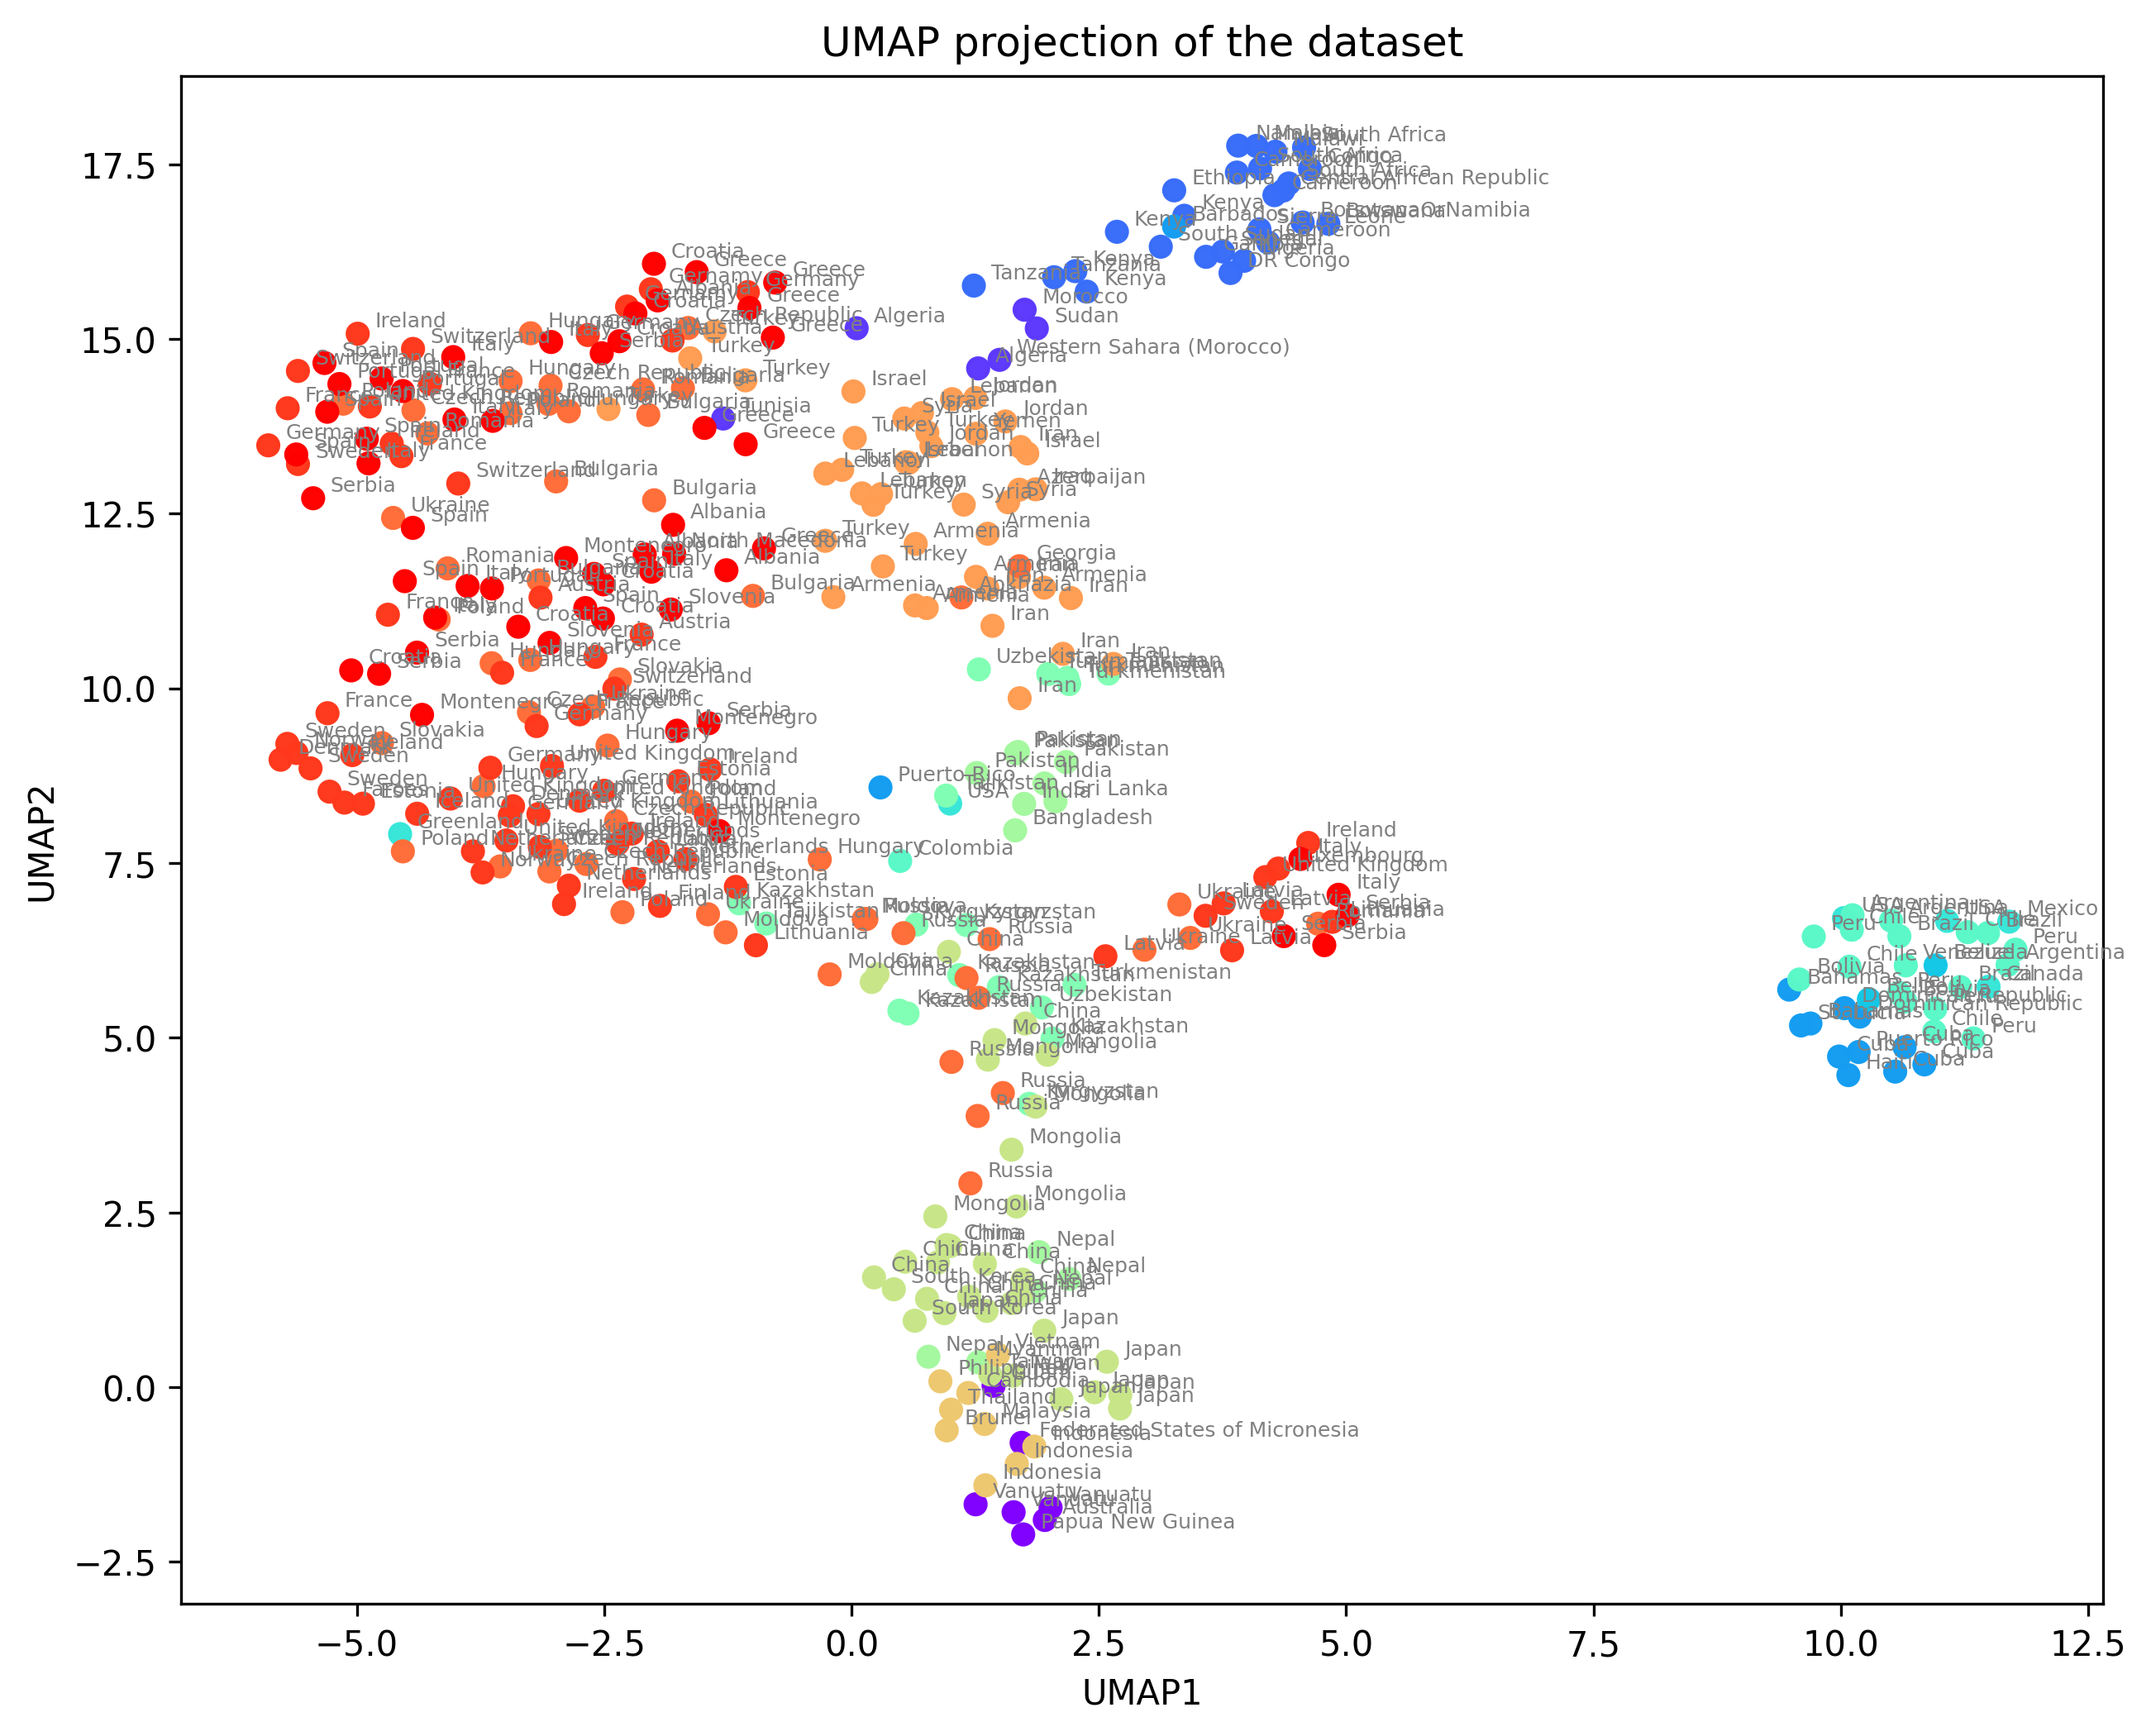

/tmp/ipykernel_12758/3083725436.py:47: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix.values, method='ward')


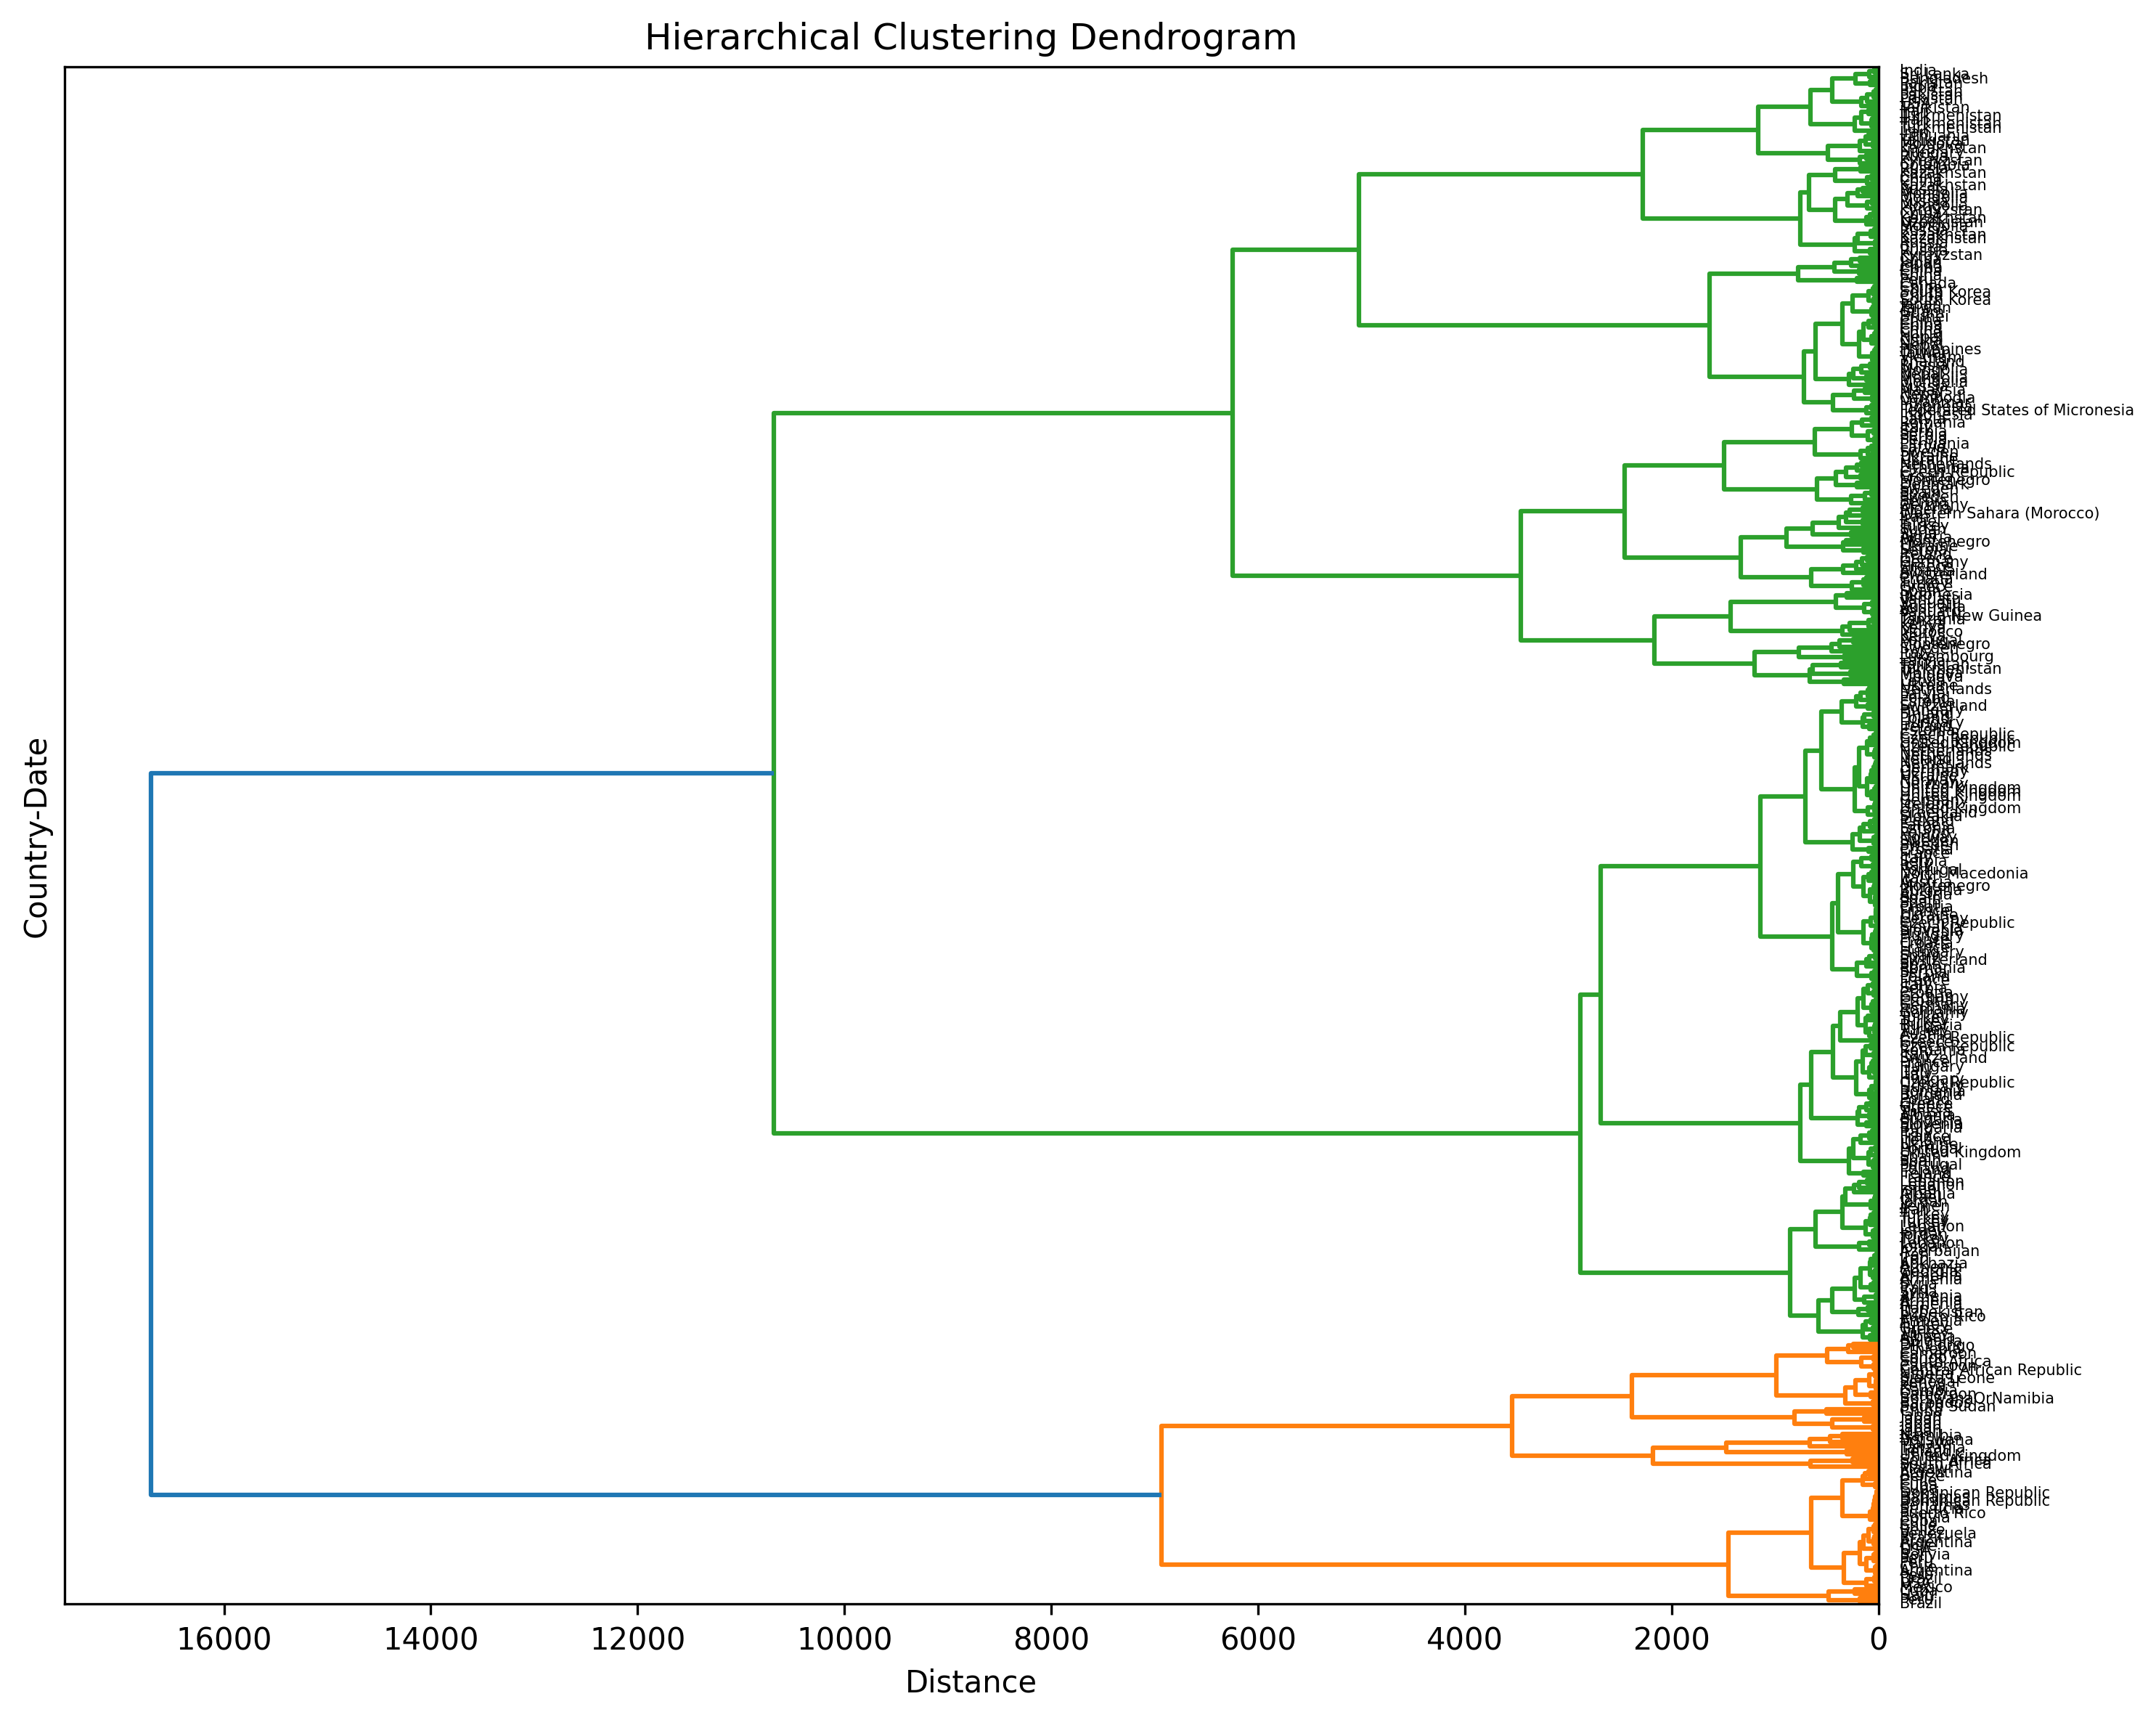

In [44]:
umap_plot(my_encoded_data, df1["country"], df1["region_code"], 18)

## save the encoded data

In [16]:
# merge df columns 1-8 with encoded data
df2 = pd.concat([df1.iloc[:, 0:8], pd.DataFrame(my_encoded_data)], axis=1)
df2.to_csv('Data/Output/1_encoded_data_frame.csv.gz', index=False, compression='gzip')
df2

,region_country__date,region_code,country_date,country,date,region,latitude,longitude,0,1,...,630,631,632,633,634,635,636,637,638,639
0,Oceania_Guam:1,0,Guam_1,Guam,1,Oceania,13.450126,144.757551,9.285117,0.000000,...,0.0,18.921244,0.0,0.0,7.384154,0.0,13.074938,0.0,0.0,0.0
1,Oceania_Federated States of Micronesia:1,0,Federated States of Micronesia_1,Federated States of Micronesia,1,Oceania,8.606235,151.832744,8.753749,0.000000,...,0.0,18.936852,0.0,0.0,7.928586,0.0,15.914807,0.0,0.0,0.0
2,Oceania_Papua New Guinea:1,0,Papua New Guinea_1,Papua New Guinea,1,Oceania,-5.681607,144.248908,8.125058,0.000000,...,0.0,19.413454,0.0,0.0,7.236454,0.0,20.206751,0.0,0.0,0.0
3,Oceania_Australia:1,0,Australia_1,Australia,1,Oceania,-24.776109,134.755000,8.210156,0.000000,...,0.0,19.694237,0.0,0.0,8.095013,0.0,18.940603,0.0,0.0,0.0
4,Oceania_Vanuatu:2,0,Vanuatu_2,Vanuatu,2,Oceania,-16.525507,168.106915,7.594887,0.000000,...,0.0,18.930788,0.0,0.0,6.933259,0.0,22.910254,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,europe_southern_Croatia:3,14,Croatia_3,Croatia,3,europe_southern,45.365844,15.657521,11.549895,7.224967,...,0.0,8.901903,0.0,0.0,15.257089,0.0,22.290625,0.0,0.0,0.0
371,europe_southern_Spain:2,14,Spain_2,Spain,2,europe_southern,39.326068,-4.837979,11.703223,7.649376,...,0.0,9.419014,0.0,0.0,14.846376,0.0,22.741592,0.0,0.0,0.0
372,europe_southern_Spain:7,14,Spain_7,Spain,7,europe_southern,39.326068,-4.837979,13.085393,13.941836,...,0.0,5.933186,0.0,0.0,12.324180,0.0,25.969839,0.0,0.0,0.0
373,europe_southern_Spain:3,14,Spain_3,Spain,3,europe_southern,39.326068,-4.837979,12.291629,8.418076,...,0.0,6.903371,0.0,0.0,14.828239,0.0,24.072744,0.0,0.0,0.0


## Testing

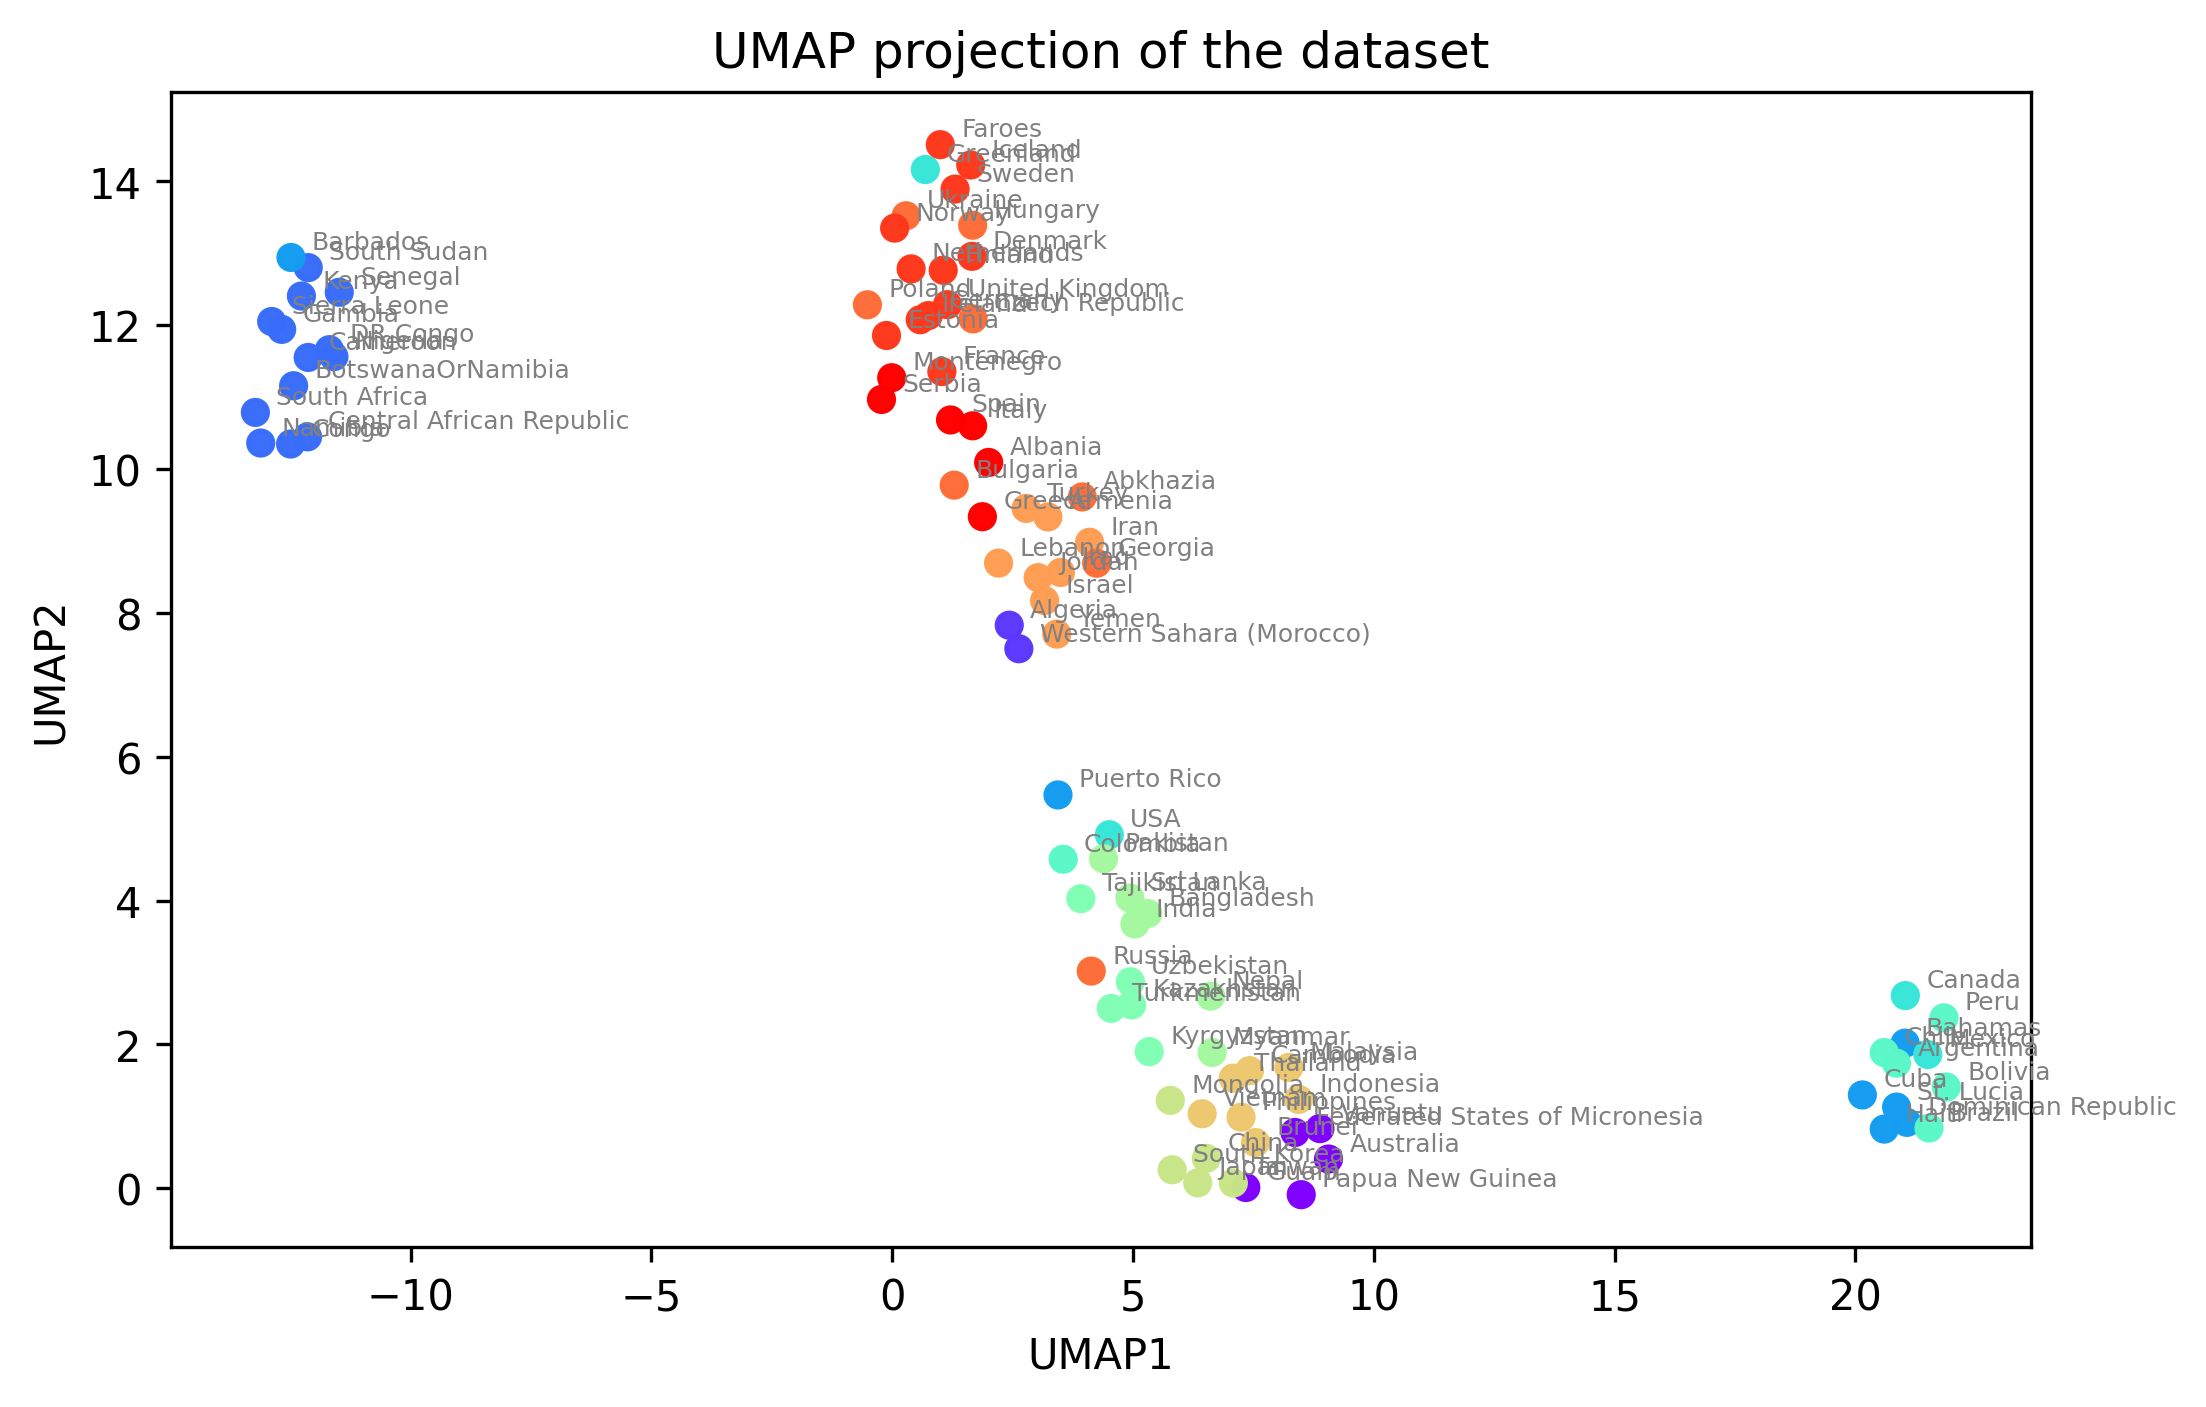

/tmp/ipykernel_12758/2143754112.py:47: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix.values, method='ward')


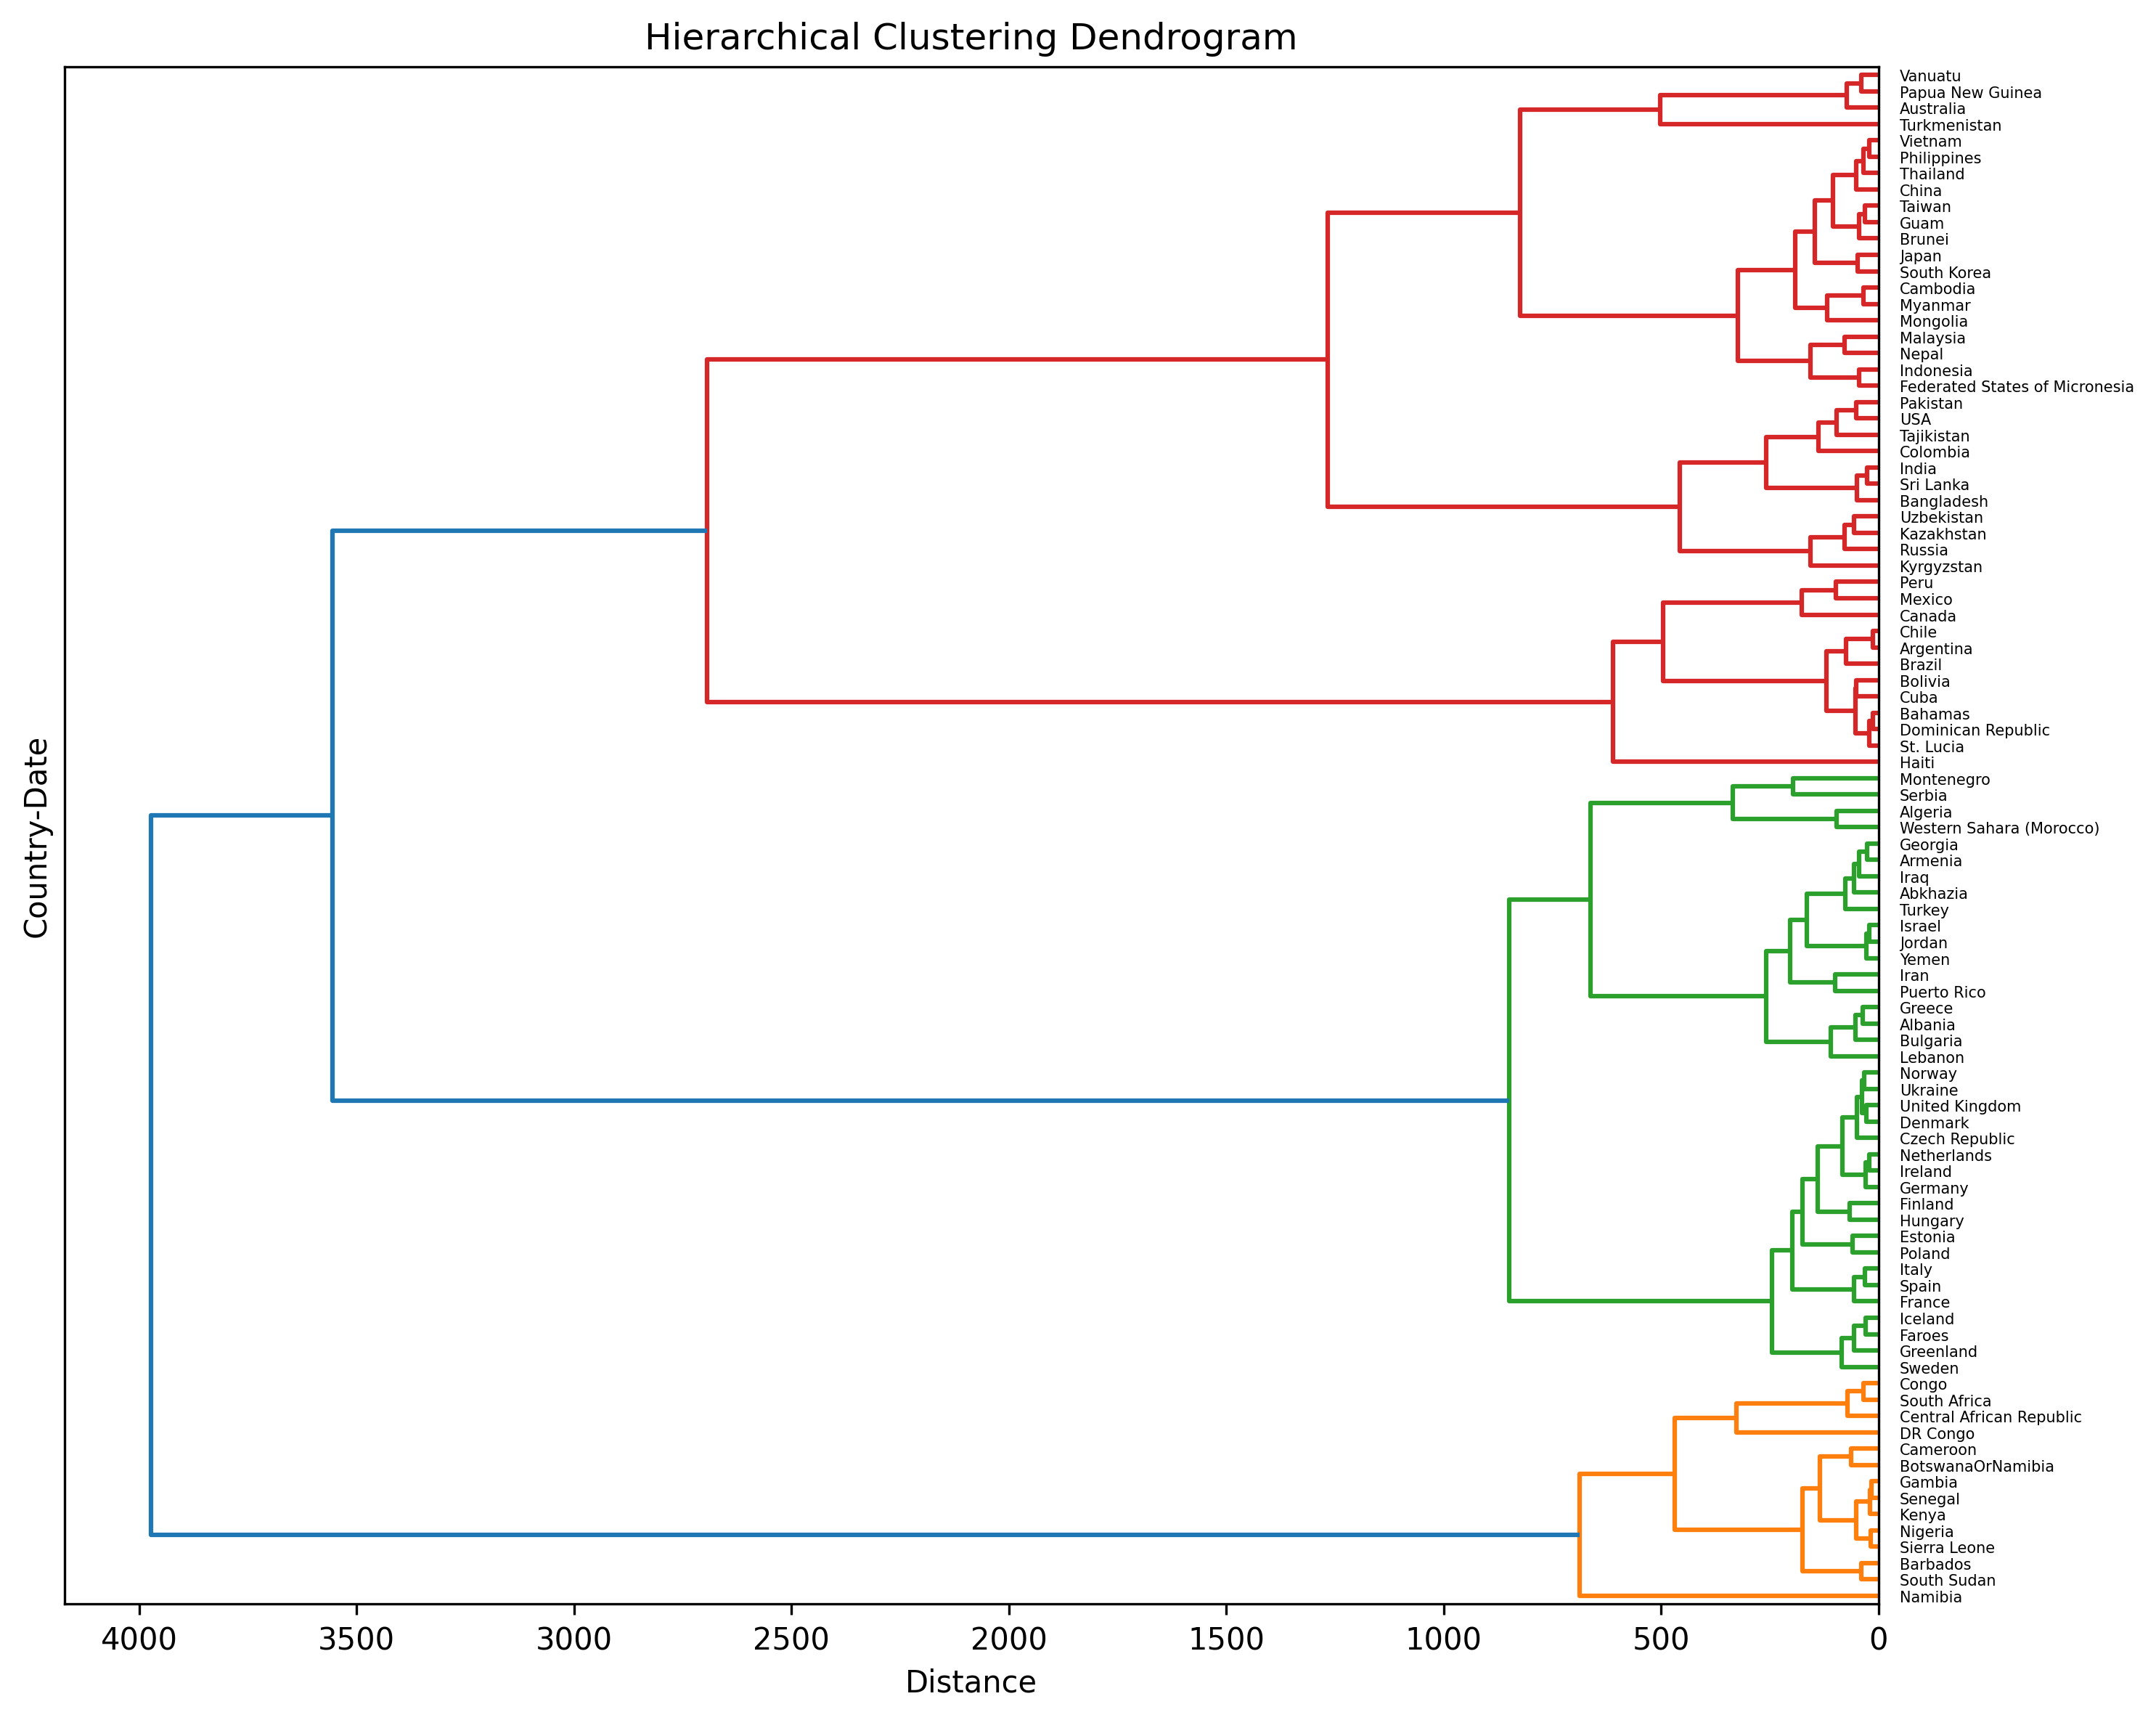

In [60]:
df_test= pd.read_csv('Data/Output/1_encoded_data_frame.csv.gz', compression='gzip')
# df3=df_test[(df_test.date==3)| (df_test.date==4)]
df3=df_test[df_test.date==1]
umap_plot(df3.iloc[:, 8:], df3["country"], df3["region_code"], 12)